In this project, we are trying to compare the performance of transformer models using the Fake news dataset.

# **1.  Setup**

In [1]:
!pip install transformers gspread gspread-dataframe

     |████████████████████████████████| 2.3MB 33.7MB/s 
     |████████████████████████████████| 3.3MB 34.9MB/s 
     |████████████████████████████████| 901kB 52.6MB/s 


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import nltk
import random
import numpy as np
import pandas as pd
import time
import datetime
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup, AdamW
from transformers import  BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
% matplotlib inline

In [3]:
EPOCHS = 4
BATCH_SIZE = 32
BERT_PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
DISTILBERT_PRE_TRAINED_MODEL_NAME = 'distilbert-base-cased'
ROBERTA_PRE_TRAINED_MODEL_NAME = 'roberta-base'

# **2. Data Exploration**

We read the training and testing datasets provided by the UTK Machine Learning Club on Kaggle. The trainig dataset has around 20000 datapoints with 5 columns.

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print("Shape of trainig dataset=%s"%train.shape)
print("Shape of testing dataset=%s"%test.shape)

In [6]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [7]:

test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [8]:
def process_train_data(data):
  text = data.text
  temp_df = pd.DataFrame()
  temp_df['content'] = text
  labels = data.label
  temp_df['labels'] = labels
  new_data = temp_df.content
  labels = temp_df.labels
  return new_data, labels

In [9]:
nltk.download('stopwords')
from nltk.corpus import stopwords
porter_stemmer = PorterStemmer()
def preprocess_text(data): 
    text = re.sub('[^a-zA-Z]',' ',data)
    text = text.lower()
    words = text.split()
    words = [porter_stemmer.stem(word) for word in words if word not in stopwords.words('english') and word.isalpha()]
    text = ' '.join(words)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We pre-process the data and add the author to the content of the article so that author also serves as criteria to classify the article as fake or real.

In [10]:
train = train.fillna('')
test = test.fillna('')
train['text'] = train['text']+ ' ' +train['author']
test['text'] = test['text']+ ' ' +test['author']
train_data, train_labels = process_train_data(train)
train['title_author'] = train['title'] + ' ' + train['author']
test['title_author'] = test['title'] + ' ' + test['author']
train['title_author'] = train['title_author'].apply(preprocess_text)
test['title_author'] = test['title_author'].apply(preprocess_text)

The following word cloud shows the top words which constitute towards real or reliable articles. New York, time, donald, michael are some of the words which are part of relaible news articles.



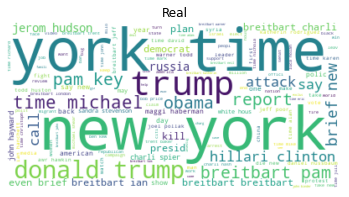

In [11]:
wordcloud = WordCloud(background_color = 'white')
wordcloud.generate(' '.join(train[train['label']==0]['title_author']))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.title('Real')
plt.axis('off')
plt.show()

The following word cloud shows the top words which constitute towards fake or unreliable articles. Trump, Hillari, new, clinton are the top words which are part of fake news.

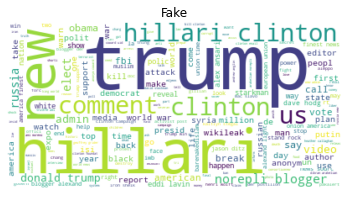

In [12]:
wordcloud = WordCloud(background_color = 'white')
wordcloud.generate(' '.join(train[train['label']==1]['title_author']))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.title('Fake')
plt.axis('off')
plt.show()

We can see that the training dataset has equal number of fake news articles and real news articles. There are over 10000 news articles for both the labels.

([<matplotlib.axis.XTick at 0x7fbd3bde1950>,
 [Text(0, 0, 'Real'), Text(0, 0, 'Fake')])

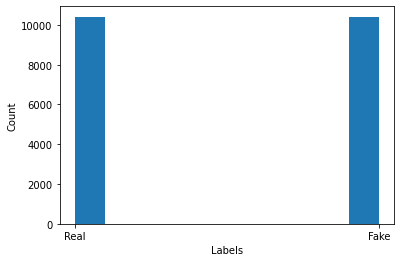

In [13]:
class_names = ["Real", "Fake"]
plt.hist(train.label)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(ticks=sorted(train.label.unique()), labels=class_names)

Text(0, 0.5, 'Count')

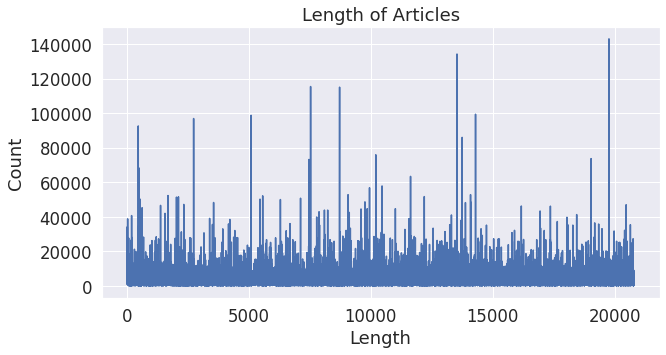

In [43]:
text_lengths = []
for content in train_data:
    text_lengths.append(len(str(content)))

plt.plot(text_lengths)
plt.title('Length of Articles')
plt.xlabel('Length')
plt.ylabel('Count')

In [16]:
train_labels = torch.tensor(list(train_labels))

In [17]:
def train_validation_split(input_ids, attention_masks, labels):
  dataset = TensorDataset(input_ids, attention_masks, labels)
  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size

  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
  return train_dataset, val_dataset

In [18]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [20]:
# If there's a GPU available...
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('%s GPU(s) available.' % torch.cuda.device_count())
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using CPU.')
    device = torch.device("cpu")

1 GPU(s) available.
Using GPU: Tesla T4


## **3 Data Preprocessing**

We use pre-trained transformer models to convert the words into token sequence so that the transformer models can understand. We use the encode_plus() method to tokenize data which returns input ids and attention mask.
<br>
BERT tokenizer uses special token [CLS] at the start of each sequence and [SEP] token to separate between two sentences.



In [21]:
def tokenize_data(data, tokenizer_class, pretrained_weights, max_length=256):
  input_ids = []
  attention_masks = []
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  for content in data:
      encoded_dict = tokenizer.encode_plus(
                          content,
                          add_special_tokens = True,
                          max_length = max_length,
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt',
                    )
      
      input_ids.append(encoded_dict['input_ids'])      
      attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  return input_ids, attention_masks

In [22]:
def test_submission_file(pred, filename):
  final_sub = pd.DataFrame()
  final_sub['id']=test['id']
  final_sub['label'] = pred
  final_sub.to_csv(filename,index=False)

In [23]:
def test_predict(model, data, tokenizer_class, pretrained_weights, batch_size=BATCH_SIZE):
  input_ids, attention_masks = tokenize_data(data, tokenizer_class, pretrained_weights)
  dataset = TensorDataset(input_ids, attention_masks)
  pred_dataloader = DataLoader(
                      dataset, 
                      sampler = SequentialSampler(dataset), 
                      batch_size = batch_size 
                      )
  preds = []
  for batch in pred_dataloader:
      batch = tuple(t.to(device) for t in batch)
      batch_input_ids, batch_input_mask = batch
      
      with torch.no_grad():
          outputs = model(batch_input_ids,
                        attention_mask = batch_input_mask)
      logits = outputs[0]
      
      logits = logits.detach().cpu().numpy()
      preds.append(logits)

  flat_preds = [item for sublist in preds for item in sublist]
  flat_preds = np.argmax(flat_preds, axis=1).flatten()
  return flat_preds


# **4. Training**

In order to train our models, we use the AdamW optimizer with learning rate of 2e-5 and adam epsilon of 1e-8. We also use a scheduler with no warmups.  We make use cross entropy loss to compute the loss as this is a classification problem. We fine-tune the models by running the training step for 5 epochs.

In [24]:
def train_model(train_dataloader, validation_dataloader, model, optimizer, scheduler, epochs=EPOCHS):
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  loss_values = []

  for epoch in range(epochs):
      print("Epoch {} / {}".format(epoch + 1, epochs))
      print("Training step:")
      start_time = time.time()
      total_loss = 0
      model.train()
      for step, batch in enumerate(train_dataloader):              
          batch_input_ids  = batch[0].to(device)
          batch_input_mask = batch[1].to(device)
          batch_labels = batch[2].to(device)
          
          model.zero_grad()
          
          outputs = model(batch_input_ids,
                        attention_mask = batch_input_mask,
                        labels = batch_labels)
          
          loss = outputs[0]
          
          total_loss += loss.item()
          
          loss.backward()
          
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()
          
      avg_train_loss = total_loss / len(train_dataloader)
      loss_values.append(avg_train_loss)
      
      print(" Average training loss: {}".format(avg_train_loss))
      print(" Training epoch took: {:}".format(format_time(time.time() - start_time)))

      print()
      print("Validation step:")
      model.eval()
      val_accuracy = 0
      val_steps = 0 
      for batch in validation_dataloader:
          batch = tuple(t.to(device) for t in batch)
          batch_input_ids, batch_input_mask, batch_labels = batch
          
          with torch.no_grad():
              outputs = model(batch_input_ids,
                            attention_mask = batch_input_mask)
          logits = outputs[0]
          
          logits = logits.detach().cpu().numpy()
          true_labels = batch_labels.to('cpu').numpy()
          
          tmp_eval_accuracy = flat_accuracy(logits, true_labels)
          
          eval_accuracy += tmp_eval_accuracy
          
          val_steps += 1
      
      print(" Accuracy: {}".format(val_accuracy/val_steps))
      print(" Validation took: {:}".format(format_time(time.time() - start_time)))
      print()
  return loss_values

**4.1.  BERT Model**
<br>
We use the bert-base-cased pre-trained model for transfer learning.



In [25]:
def bert_model_train(data, learning_rate, adam_epsilon, epochs=EPOCHS, batch_size=BATCH_SIZE):

  input_ids, attention_masks = tokenize_data(data, BertTokenizer, BERT_PRE_TRAINED_MODEL_NAME, max_length=256)
  model = BertForSequenceClassification.from_pretrained(
            BERT_PRE_TRAINED_MODEL_NAME,
            num_labels = 2,
            output_attentions = False, 
            output_hidden_states = False, 
            )
  model.cuda()

  train_dataset, val_dataset = train_validation_split(input_ids, attention_masks, train_labels)

  train_dataloader = DataLoader(
                      train_dataset,
                      sampler = RandomSampler(train_dataset), 
                      batch_size = batch_size 
                      )

  validation_dataloader = DataLoader(
                            val_dataset, 
                            sampler = SequentialSampler(val_dataset), 
                            batch_size = batch_size 
                            )
  
  optimizer = AdamW(model.parameters(), lr = learning_rate, eps = adam_epsilon)
  total_steps = len(train_dataloader)*epochs

  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

  loss = train_model(train_dataloader, validation_dataloader, model, optimizer, scheduler, epochs)
  torch.save(model, "BERT_Model")

  return loss 

**4.2.  DistilBERT Model**
<br>
We use the distilbert-base-cased pre-trained model for transfer learning.

In [26]:
def distilbert_model_train(data, learning_rate, adam_epsilon, epochs=EPOCHS, batch_size=BATCH_SIZE):

  input_ids, attention_masks = tokenize_data(data, DistilBertTokenizer, DISTILBERT_PRE_TRAINED_MODEL_NAME, max_length=256)
  model = DistilBertForSequenceClassification.from_pretrained(
            DISTILBERT_PRE_TRAINED_MODEL_NAME,
            num_labels = 2,
            output_attentions = False, 
            output_hidden_states = False, 
            )
  model.cuda()

  train_dataset, val_dataset = train_validation_split(input_ids, attention_masks, train_labels)

  train_dataloader = DataLoader(
                      train_dataset,
                      sampler = RandomSampler(train_dataset), 
                      batch_size = batch_size 
                      )

  validation_dataloader = DataLoader(
                            val_dataset, 
                            sampler = SequentialSampler(val_dataset), 
                            batch_size = batch_size 
                            )
  
  optimizer = AdamW(model.parameters(), lr = learning_rate, eps = adam_epsilon)
  total_steps = len(train_dataloader)*epochs

  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

  loss = train_model(train_dataloader, validation_dataloader, model, optimizer, scheduler, epochs)
  torch.save(model, "DistilBERT_Model")
  return loss 

**4.2.  RoBERTa Model**
<br>
We use the roberta-base pre-trained model for transfer learning.

In [27]:
def roberta_model_train(data, learning_rate, adam_epsilon, epochs=EPOCHS, batch_size=BATCH_SIZE):
  input_ids, attention_masks = tokenize_data(data, RobertaTokenizer, ROBERTA_PRE_TRAINED_MODEL_NAME, max_length=256)
  model = RobertaForSequenceClassification.from_pretrained(
            ROBERTA_PRE_TRAINED_MODEL_NAME,
            num_labels = 2,
            output_attentions = False, 
            output_hidden_states = False, 
            )
  model.cuda()

  train_dataset, val_dataset = train_validation_split(input_ids, attention_masks, train_labels)

  train_dataloader = DataLoader(
                      train_dataset,
                      sampler = RandomSampler(train_dataset), 
                      batch_size = batch_size 
                      )

  validation_dataloader = DataLoader(
                            val_dataset, 
                            sampler = SequentialSampler(val_dataset), 
                            batch_size = batch_size 
                            )
  
  optimizer = AdamW(model.parameters(), lr = learning_rate, eps = adam_epsilon)
  total_steps = len(train_dataloader)*epochs

  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

  loss = train_model(train_dataloader, validation_dataloader, model, optimizer, scheduler, epochs)
  torch.save(model, "RoBERTa_Model")
  return loss 

In [28]:
bert_loss = bert_model_train(train_data, learning_rate=2e-5, adam_epsilon=1e-8, epochs=EPOCHS, batch_size=BATCH_SIZE)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Epoch 1 / 4

 Average training loss: 0.11870470245400619
 Training epoch took: 0:03:39

Running validation...
 Accuracy: 0.9798076923076923
 Validation took: 0:03:47
Epoch 2 / 4

 Average training loss: 0.0339626674576161
 Training epoch took: 0:03:44

Running validation...
 Accuracy: 0.9899038461538462
 Validation took: 0:03:52
Epoch 3 / 4

 Average training loss: 0.00876194809712211
 Training epoch took: 0:03:43

Running validation...
 Accuracy: 0.9879807692307693
 Validation took: 0:03:51
Epoch 4 / 4

 Average training loss: 0.0027395234932975233
 Training epoch took: 0:03:43

Running validation...
 Accuracy: 0.9884615384615385
 Validation took: 0:03:51
Training complete!
 Validation Accuracy = 0.9884615384615385



In [29]:
distilbert_loss = distilbert_model_train(train_data, learning_rate=2e-5, adam_epsilon=1e-8, epochs=EPOCHS, batch_size=BATCH_SIZE)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.wei

Epoch 1 / 4

 Average training loss: 0.12926575552381606
 Training epoch took: 0:01:53

Running validation...
 Accuracy: 0.9778846153846154
 Validation took: 0:01:57
Epoch 2 / 4

 Average training loss: 0.04070978038541328
 Training epoch took: 0:01:52

Running validation...
 Accuracy: 0.9802884615384615
 Validation took: 0:01:56
Epoch 3 / 4

 Average training loss: 0.014349505256311212
 Training epoch took: 0:01:51

Running validation...
 Accuracy: 0.9865384615384616
 Validation took: 0:01:55
Epoch 4 / 4

 Average training loss: 0.004429170209989071
 Training epoch took: 0:01:51

Running validation...
 Accuracy: 0.9879807692307693
 Validation took: 0:01:55
Training complete!
 Validation Accuracy = 0.9879807692307693



In [30]:
roberta_loss = roberta_model_train(train_data, learning_rate=2e-5, adam_epsilon=1e-8, epochs=EPOCHS, batch_size=BATCH_SIZE)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Epoch 1 / 4

 Average training loss: 0.07148883101892554
 Training epoch took: 0:03:48

Running validation...
 Accuracy: 0.9932692307692308
 Validation took: 0:03:57
Epoch 2 / 4

 Average training loss: 0.015746126337035093
 Training epoch took: 0:03:46

Running validation...
 Accuracy: 0.9860576923076924
 Validation took: 0:03:54
Epoch 3 / 4

 Average training loss: 0.004646057584669996
 Training epoch took: 0:03:46

Running validation...
 Accuracy: 0.9908653846153846
 Validation took: 0:03:54
Epoch 4 / 4

 Average training loss: 0.0024320467035394335
 Training epoch took: 0:03:46

Running validation...
 Accuracy: 0.9913461538461539
 Validation took: 0:03:54
Training complete!
 Validation Accuracy = 0.9913461538461539



We can see from the following graph that the RoBERTa model outperforms the BERT and DistilBERT models.

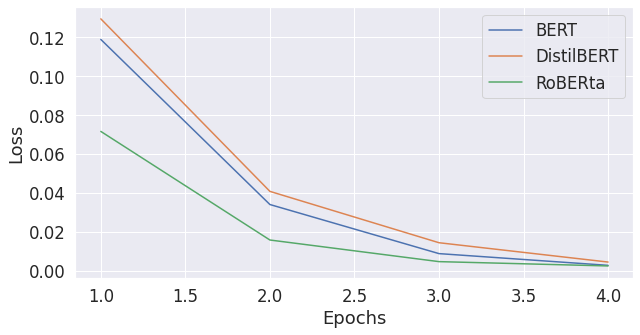

In [31]:
eps = [1,2,3,4]
plt.plot(eps,bert_loss)
plt.plot(eps,distilbert_loss)
plt.plot(eps, roberta_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["BERT", "DistilBERT", "RoBERta"])
plt.show()

# **5. Testing**

In [36]:
bert_model = torch.load("BERT_Model")
bert_model.eval()
bert_y_pred = test_predict(bert_model, test.text, BertTokenizer, BERT_PRE_TRAINED_MODEL_NAME)
test_submission_file(bert_y_pred, 'BERT_submission.csv')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [37]:
distilbert_model = torch.load("DistilBERT_Model")
distilbert_model.eval()
distilbert_y_pred = test_predict(distilbert_model, test.text, DistilBertTokenizer, DISTILBERT_PRE_TRAINED_MODEL_NAME)
test_submission_file(distilbert_y_pred, 'DistilBERT_submission.csv')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [38]:
roberta_model = torch.load("RoBERTa_Model")
roberta_model.eval()
roberta_y_pred = test_predict(roberta_model, test.text, RobertaTokenizer, ROBERTA_PRE_TRAINED_MODEL_NAME)
test_submission_file(roberta_y_pred, 'RoBERTa_submission.csv')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Following is the screenshot of our submission on Kaggle for test dataset.
<br>
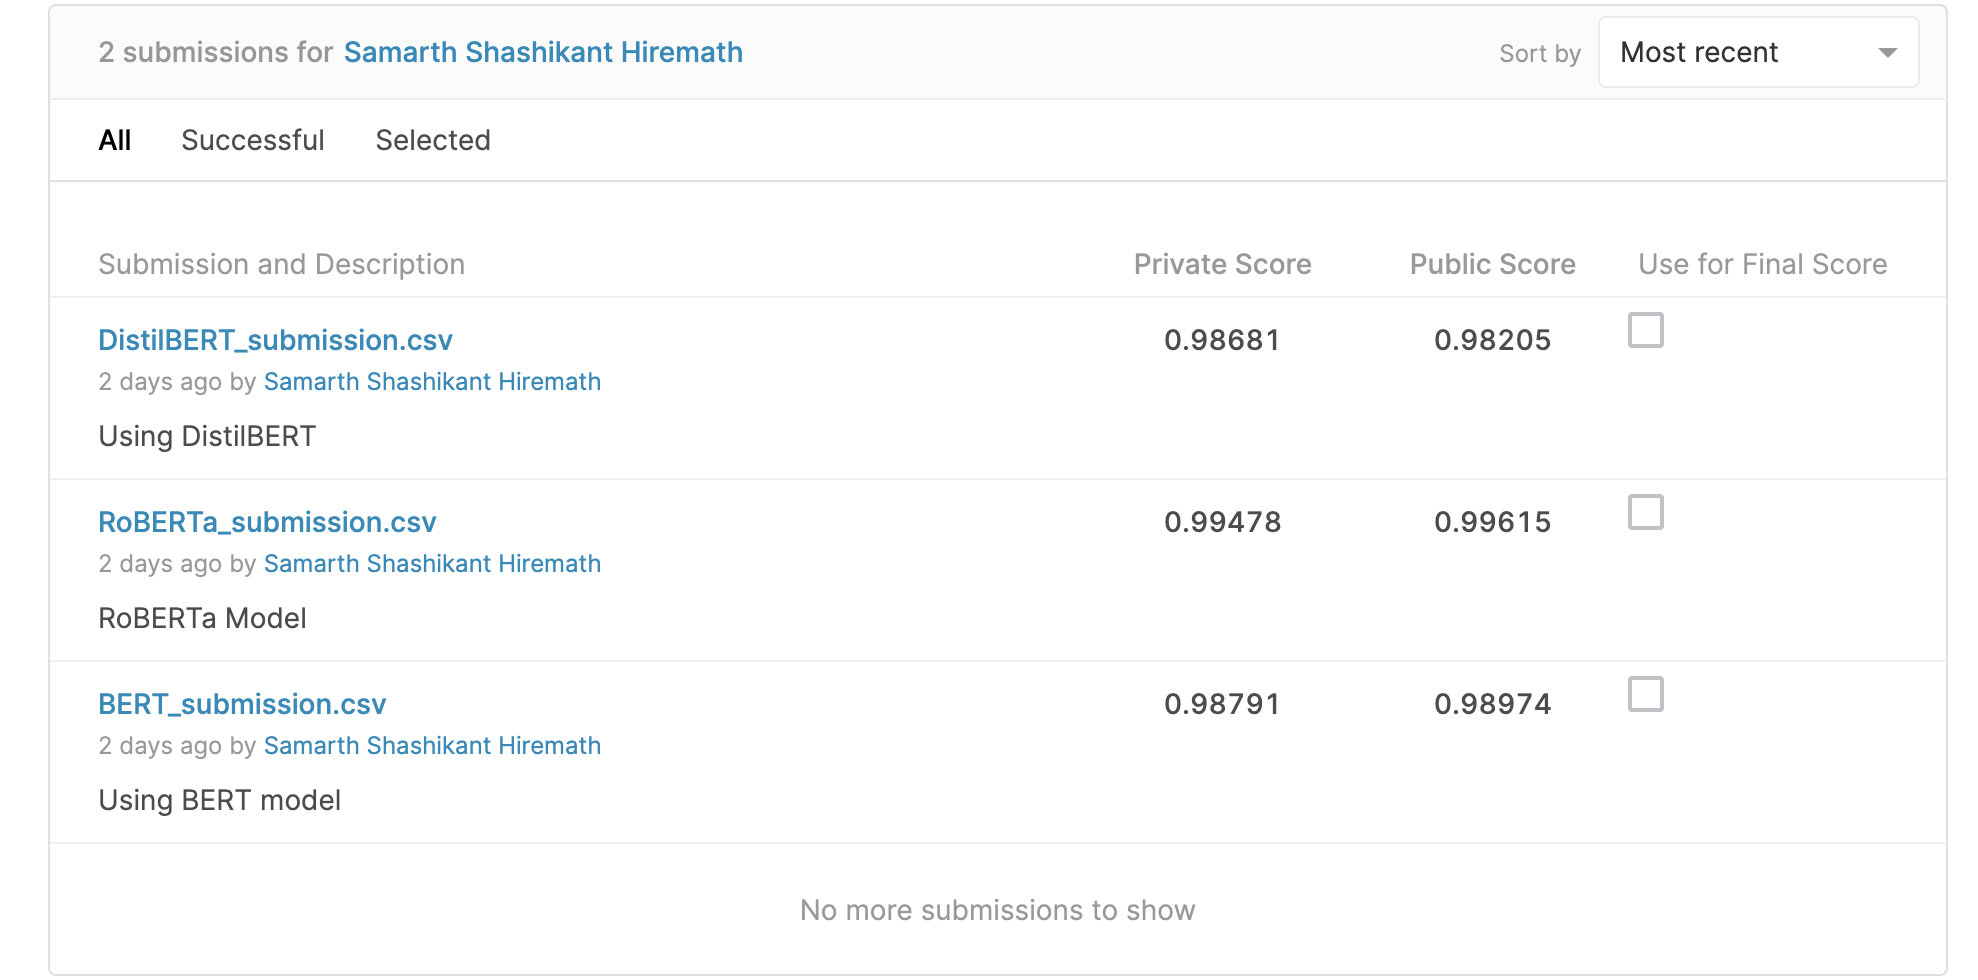